## Overview

This model is intended to be used to more accurately estimate the effort required to complete model based development (MBD) activities. Most commercial bidding and estimating tools do not differentiate between programming languages, and they definitely do not account for the differences between hand coding and MBD. This can lead to large discrepancies in between the hours bid and the hours required to actually complete the activity.  We are focusing on MATLAB/Simulink in this model, however it could be expanded to include other MBD tools. 

#### Model Based Development

MBD is a method of software development that is used the aerospace, automotive, and industrial equipment industries in applications with complex controls and signal processing. MBD offers some advantages in prototyping and testing over more traditional hand coding in these applications. An example application of MBD using Simulink, an anti-lock breaking system, can be found on [Mathworks](https://www.mathworks.com/help/simulink/slref/modeling-an-anti-lock-braking-system.html). C/C++ code is generated from the model and then compiled for use in the final application.

## Estimation

Engineering bidding tools generally use Source Lines of Code (SLOC) counts as the primary variable when determining the hours required to complete a software task. However, SLOC counts from generated code do not line up 1:1 with hand coded SLOC counts for similar features. A more accurate approach would be to base the estimate on existing activities that used the same programming language.

## Model Development

This model was developed to estimate bid hours for three programming languages that are common in the aerospace, automotive, and industrial equipment industries; Ada, C#, and Simulink. Since actual charge activities and SLOC counts are not publicly available the model was trained and tested using generated activities. The sloc_hours.py file in this repo was used to generate the data set. 

#### Assumptions and Limitations

This is a simplified model that does not take into account any other variables that may be found in commercial bidding tools. Examples of these variables are: certification level, stability of the code base, and development methodology. These variables were omitted due to the lack of publicly available data. The generated data would either over or under weight the other variables and the resulting model would not provide any insight into the impact of those variables on a real activity. 

In order to use this model with real world data, additional analysis and model tuning would need to be done in order to get the best model fit.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


df = pd.read_csv('activities.csv')
df.head()

,activity_id,programming_language,sloc,hours
0,1,Ada,889,3161
1,2,Ada,575,1639
2,3,C#,530,1806
3,4,Simulink,583,1700
4,5,Simulink,341,1162


In [2]:
df.describe()

,activity_id,sloc,hours
count,4000.000000,4000.000000,4000.000000
mean,2000.500000,698.576500,2202.355000
std,1154.844867,228.298876,740.558967
min,1.000000,300.000000,551.000000
25%,1000.750000,501.000000,1590.000000
50%,2000.500000,698.000000,2177.500000
75%,3000.250000,894.000000,2785.000000
max,4000.000000,1100.000000,4245.000000


In [3]:
pd.pivot_table(df, values=['sloc', 'hours'], 
                             index='programming_language', 
                             aggfunc='mean')

,hours,sloc
programming_language,,
Ada,2430.132609,705.147101
C#,1974.980436,692.584650
Simulink,2192.941905,697.721146


There is quite a bit of overlap in the scatter plot for all three languages. However, especially for the higher SLOC counts, there is around a 2,000 hours difference between the smallest and largest hours values for C# and Ada. 

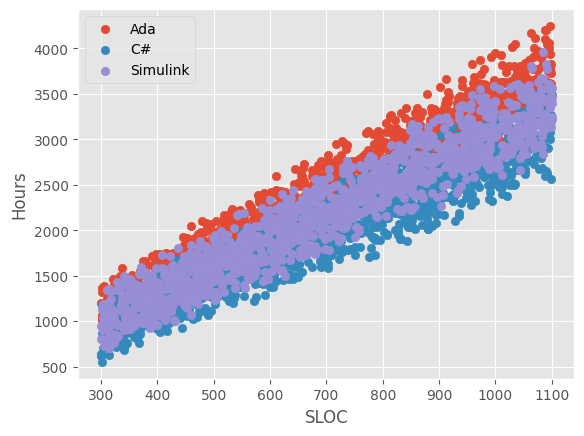

In [4]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
for name, group in df.groupby('programming_language'):
    ax.scatter(
        group['sloc'], group['hours'], label=name)
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.legend()

Splitting the dataframe by language for more visualization. The origianal df with all three languages will be used for the final model, however splitting and modeling each individually will allow us to visualize the results, and provide a basis for comparison for the estimates from the overall model

In [5]:
df_simulink = df.loc[lambda x: x['programming_language'] == 'Simulink']
df_c = df.loc[lambda x: x['programming_language'] == 'C#']
df_ada = df.loc[lambda x: x['programming_language'] == 'Ada']

In [6]:
# The first model will be Simulink only
data_train, data_test = train_test_split(df_simulink, test_size=0.2)

# Selecting X and y for the training and test data sets
X_train = data_train.drop(['hours','activity_id'], axis=1)
y_train = data_train.hours
X_test = data_test.drop(['hours', 'activity_id'], axis=1)
y_test = data_test.hours

# Using OneHotEncoder to encode all categorical data as numerical. 
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(include=['object']).columns, drop_first=True)

In [7]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1032 entries, 1845 to 3515
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sloc    1032 non-null   int64
dtypes: int64(1)
memory usage: 16.1 KB


In [8]:
# Training the model
lm = LinearRegression() 
  
model = lm.fit(X_train, y_train) 
print(lm.score(X_test, y_test)) 

0.9141939876371954


In [9]:
y_pred = lm.predict(X_test) 

Although the MAE and RMSE are not small, given the scale of the predicted value, these errors are not unreasonable.

In [10]:
# Calcualting error
from sklearn.metrics import mean_absolute_error,mean_squared_error 
  
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("Mean Absolute Error:",mae) 
print("Mean Squared Error:",mse) 
print("Root Mean Squared Error:",rmse)


Mean Absolute Error: 172.70400996986186
Mean Squared Error: 43847.94795672831
Root Mean Squared Error: 209.39901613123286


C:\Users\megha\Documents\jupyter\my-venv\my-venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Plot of $\hat{y}$ with the Simulink training data.

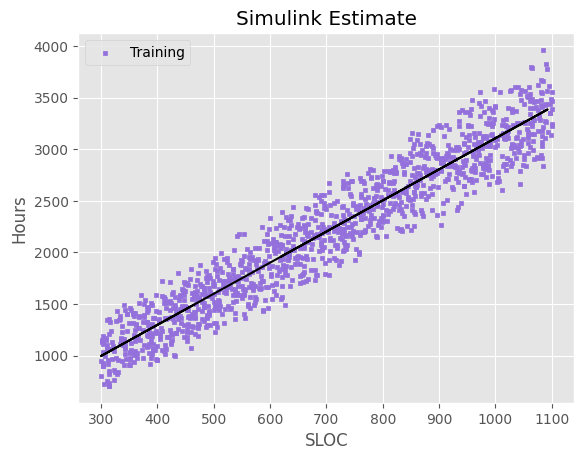

In [11]:
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_simulink['sloc'], df_simulink['hours'], s=10, c='mediumpurple', marker="s", label='Training')
plt.plot(X_test, y_pred,color='k')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('Simulink Estimate')
plt.show()

In [12]:
# Create dataframe to estimate a single activity
d = {'sloc': [600]}

features = pd.DataFrame(data=d)

In [13]:
# Use the lm model to estimate hours
prediction = lm.predict(features)
features.insert(1, 'hours', prediction, True)
print(prediction)

[1901.27389631]


In [14]:
features.head()

,sloc,hours
0,600,1901.273896


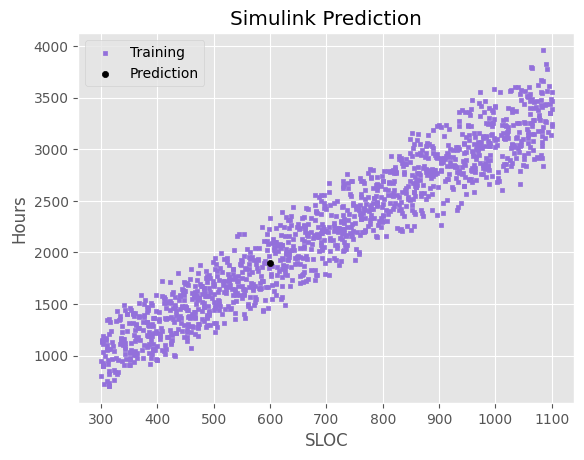

In [15]:
# Plot to show the new prediction with the Simulink training data.
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_simulink['sloc'], df_simulink['hours'], s=10, c='mediumpurple', marker="s", label='Training')
ax1.scatter(features['sloc'], features['hours'], s=20, c='k', marker="o", label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('Simulink Prediction')
plt.show()

In [16]:
# Second model is C#
data_train, data_test = train_test_split(df_c, test_size=0.2)

# Selecting X and y for the training and test data sets
X_train = data_train.drop(['hours','activity_id'], axis=1)
y_train = data_train.hours
X_test = data_test.drop(['hours', 'activity_id'], axis=1)
y_test = data_test.hours

# Using OneHotEncoder to encode all categorical data as numerical. 
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(include=['object']).columns, drop_first=True)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1063 entries, 2144 to 436
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sloc    1063 non-null   int64
dtypes: int64(1)
memory usage: 16.6 KB


In [18]:
# Training the model
lm = LinearRegression() 
  
model = lm.fit(X_train, y_train) 
print(lm.score(X_test, y_test)) 

0.9061119524152674


In [19]:
y_pred = lm.predict(X_test) 

In [20]:
# Calculating Errors
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("Mean Absolute Error:",mae) 
print("Mean Squared Error:",mse) 
print("Root Mean Squared Error:",rmse)


Mean Absolute Error: 161.9678761903765
Mean Squared Error: 37522.149132022336
Root Mean Squared Error: 193.70634768128363


C:\Users\megha\Documents\jupyter\my-venv\my-venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Plot of $\hat{y}$ with the C# training data.

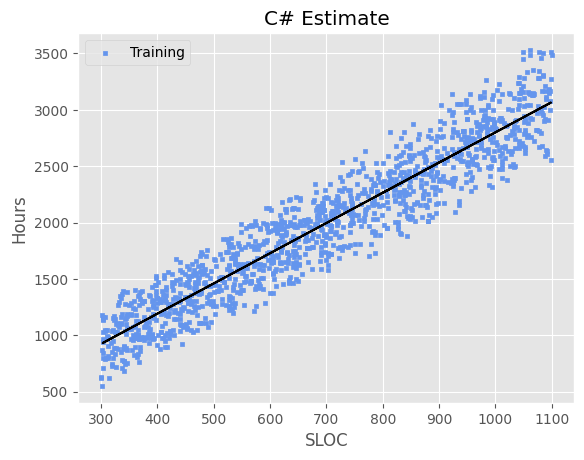

In [21]:
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_c['sloc'], df_c['hours'], s=10, c='cornflowerblue', marker="s", label='Training')
plt.plot(X_test, y_pred,color='k')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('C# Estimate')
plt.show()

In [22]:
# Create a dataframe to predict a single activity.
d = {'sloc': [600]}

features = pd.DataFrame(data=d)

In [23]:

prediction = lm.predict(features)
features.insert(1, 'hours', prediction, True)
print(prediction)

[1727.81630417]


In [24]:
features.head()

,sloc,hours
0,600,1727.816304


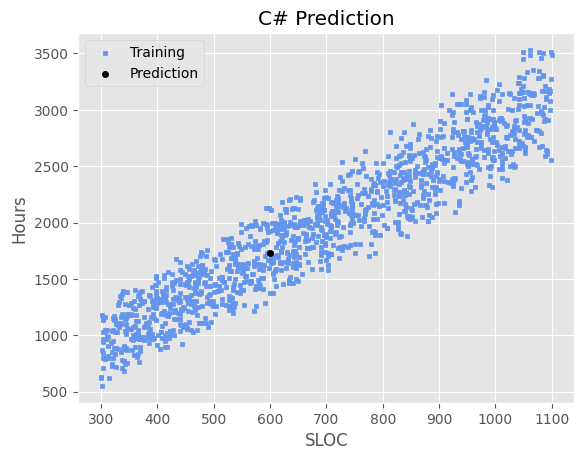

In [25]:
# Plot of the C# estimate with the training data
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_c['sloc'], df_c['hours'], s=10, c='cornflowerblue', marker="s", label='Training')
ax1.scatter(features['sloc'], features['hours'], s=20, c='k', marker="o", label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('C# Prediction')
plt.show()

In [26]:
df_ada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   activity_id           1380 non-null   int64 
 1   programming_language  1380 non-null   object
 2   sloc                  1380 non-null   int64 
 3   hours                 1380 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.9+ KB


The third model is for Ada

In [27]:
data_train, data_test = train_test_split(df_ada, test_size=0.2)

# Selecting X and y for the training and test data sets
X_train = data_train.drop(['hours','activity_id'], axis=1)
y_train = data_train.hours
X_test = data_test.drop(['hours', 'activity_id'], axis=1)
y_test = data_test.hours

# Using OneHotEncoder to encode all categorical data as numerical. 
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(include=['object']).columns, drop_first=True)

In [28]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1104 entries, 849 to 2174
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sloc    1104 non-null   int64
dtypes: int64(1)
memory usage: 17.2 KB


In [29]:
# Training the model
lm = LinearRegression() 
  
model = lm.fit(X_train, y_train) 
print(lm.score(X_test, y_test)) 

0.9179856157331957


In [30]:
y_pred = lm.predict(X_test) 

In [31]:
# Calculating errors
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("Mean Absolute Error:",mae) 
print("Mean Squared Error:",mse) 
print("Root Mean Squared Error:",rmse)


Mean Absolute Error: 186.21670037079934
Mean Squared Error: 50913.83228065675
Root Mean Squared Error: 225.6409366242233


C:\Users\megha\Documents\jupyter\my-venv\my-venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Plot of $\hat{y}$ with the Ada training data.

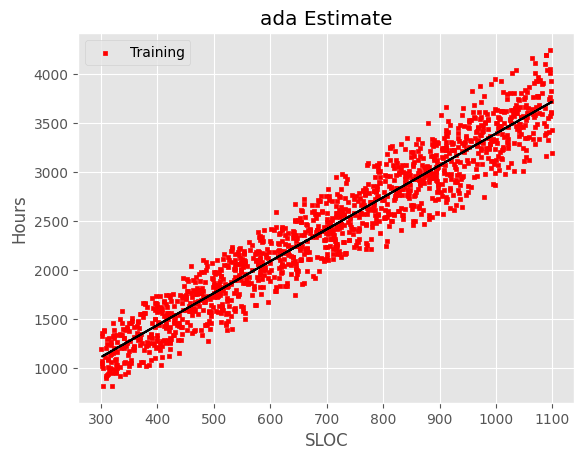

In [32]:
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_ada['sloc'], df_ada['hours'], s=10, c='red', marker="s", label='Training')
plt.plot(X_test, y_pred,color='k')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('ada Estimate')
plt.show()

In [33]:
# Create dataframe to predict a single point
d = {'sloc': [600]}

features = pd.DataFrame(data=d)

In [34]:

prediction = lm.predict(features)
features.insert(1, 'hours', prediction, True)
print(prediction)

[2088.98468835]


In [35]:
features.head()

,sloc,hours
0,600,2088.984688


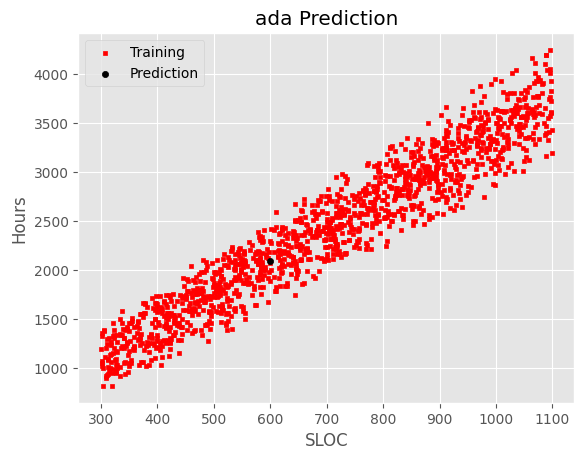

In [36]:
plt.style.use('ggplot')
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df_ada['sloc'], df_ada['hours'], s=10, c='red', marker="s", label='Training')
ax1.scatter(features['sloc'], features['hours'], s=20, c='k', marker="o", label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('ada Prediction')
plt.show()

The final model combines all three languages. This model will be used in the interactive app.

In [37]:
data_train, data_test = train_test_split(df, test_size=0.2)

# Selecting X and y for the training and test data sets
X_train = data_train.drop(['hours','activity_id'], axis=1)
y_train = data_train.hours
X_test = data_test.drop(['hours', 'activity_id'], axis=1)
y_test = data_test.hours


# Using OneHotEncoder to encode all categorical data as numerical. 
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(include=['object']).columns, drop_first=True)

In [38]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 2414 to 1680
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   sloc                           3200 non-null   int64
 1   programming_language_C#        3200 non-null   bool 
 2   programming_language_Simulink  3200 non-null   bool 
dtypes: bool(2), int64(1)
memory usage: 56.2 KB


In [39]:
# Training the model
lm = LinearRegression() 
  
model = lm.fit(X_train, y_train) 
print(lm.score(X_test, y_test)) 

0.9095392056750161


In [40]:
y_pred = lm.predict(X_test) 

In [41]:
# Calculating errors
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("Mean Absolute Error:",mae) 
print("Mean Squared Error:",mse) 
print("Root Mean Squared Error:",rmse)


Mean Absolute Error: 178.09231861525876
Mean Squared Error: 47817.3292839198
Root Mean Squared Error: 218.67173864932752


C:\Users\megha\Documents\jupyter\my-venv\my-venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
# Using pickle to save the model. This .sav model will be used in the final app
import pickle

# save the model to disk
model_filename = 'overall_model.sav'
pickle.dump(model, open(model_filename, 'wb'))

In [43]:
# load the model from disk
loaded_model = pickle.load(open(model_filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(round(result, 4))

0.9095


In [44]:
# Creating a dataframe with one point for each language.
d = {'sloc': [600, 600, 600], 'programming_language_C#': [0, 1, 0], 'programming_language_Simulink': [0, 0, 1]}

features = pd.DataFrame(data=d)

In [45]:
# Using the model from the .sav file to make the prediction
prediction = loaded_model.predict(features)
features.insert(1, 'hours', prediction, True)
print(prediction)

[2117.54494771 1695.52258652 1899.94310802]


In [46]:
features.head()

,sloc,hours,programming_language_C#,programming_language_Simulink
0,600,2117.544948,0,0
1,600,1695.522587,1,0
2,600,1899.943108,0,1


While the exact estimate for the overall model is not exactly the same as the individual language models, they are all within about 30 hours. Usi600 SLOC for each we can see the difference that including the language makes to the final estimates. There is a range of over 450 hours between the three estimates. 

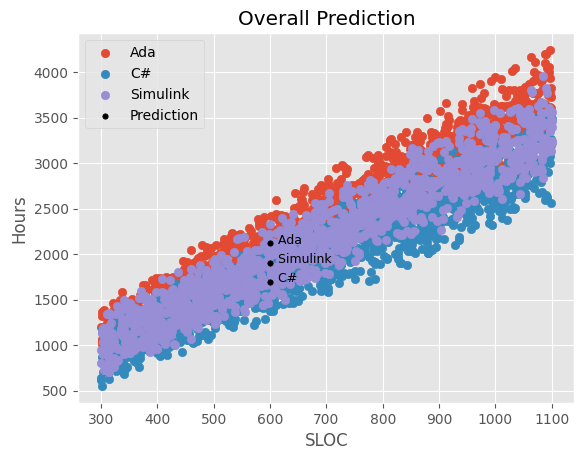

In [47]:
fig, ax = plt.subplots()
for name, group in df.groupby('programming_language'):
    ax.scatter(
        group['sloc'], group['hours'], label=name)

ax.scatter(features['sloc'], features['hours'], s=15, c='k', marker="o", label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('Overall Prediction')
txt = ['  Ada', '  C#', '  Simulink']
for i in range(len(txt)):
    plt.text(features.iloc[i, 0], features.iloc[i, 1], txt[i],fontsize=9)
plt.show()


One last model that does not take the language into account at all. This will illustrate how far off our estimates can be using the standard bidding tools.

In [48]:
# drop the language column
df_no_lan = df.drop('programming_language', axis=1)

In [49]:
data_train, data_test = train_test_split(df_no_lan, test_size=0.2)

# Selecting X and y for the training and test data sets
X_train = data_train.drop(['hours','activity_id'], axis=1)
y_train = data_train.hours
X_test = data_test.drop(['hours', 'activity_id'], axis=1)
y_test = data_test.hours


# No need to encode because there are no categorical columns anymore

In [50]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 3341 to 2519
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sloc    3200 non-null   int64
dtypes: int64(1)
memory usage: 50.0 KB


In [51]:
# Training the model
lm = LinearRegression() 
  
model = lm.fit(X_train, y_train) 
print(lm.score(X_test, y_test)) 

0.8561199881308981


In [52]:
y_pred = lm.predict(X_test) 

In [53]:
# Calculating errors
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("Mean Absolute Error:",mae) 
print("Mean Squared Error:",mse) 
print("Root Mean Squared Error:",rmse)


Mean Absolute Error: 221.71226434135008
Mean Squared Error: 76848.96033204782
Root Mean Squared Error: 277.2164503272629


C:\Users\megha\Documents\jupyter\my-venv\my-venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [54]:
# Creating a dataframe with one point for each language.
d = {'sloc': [1050]}

features = pd.DataFrame(data=d)

In [55]:
# Using the model from the .sav file to make the prediction
prediction = lm.predict(features)
features.insert(1, 'hours', prediction, True)
print(prediction)

[3258.83796262]


In [56]:
features.head()

,sloc,hours
0,1050,3258.837963


With this sample dataset, a language agnostic model would overestimate a C# activity by up to 750 hours and underestimate an Ada activity by the same margin. If we have an equal number of projects that are awarded for each language, the overall budget may balance out. However for accurate project planning and metrics tracking, these margins are far too large.

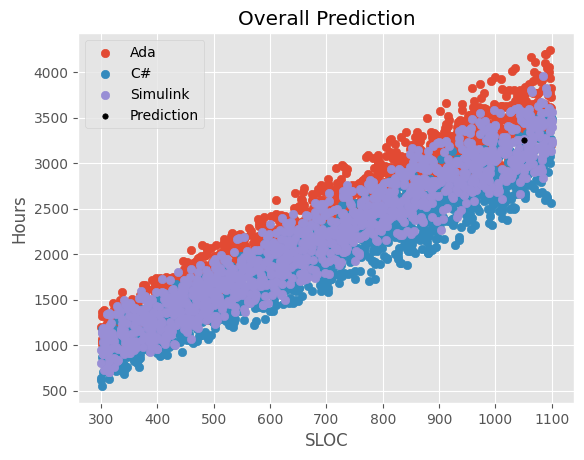

In [57]:
fig, ax = plt.subplots()
for name, group in df.groupby('programming_language'):
    ax.scatter(
        group['sloc'], group['hours'], label=name)

ax.scatter(features['sloc'], features['hours'], s=15, c='k', marker="o", label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('SLOC')
plt.ylabel('Hours')
plt.suptitle('')
plt.title('Overall Prediction')

plt.show()
